In [2]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

# Import data

In [3]:
# load data
week_dict = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 'Thursday':5, 'Friday':6, 'Saturday':7}
daily = pd.read_csv('../Data/salesdaily.csv', index_col=0)
daily['Weekday Num'] = [week_dict[day] for day in daily['Weekday Name']]
drug_list = daily.columns[:8]
daily.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,Weekday Num
datum,,,,,,,,,,,,,
1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday,5
1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday,6
1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday,7
1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday,1
1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday,2


In [4]:
# Center data
daily_centered = daily.copy()
daily_centered[drug_list] = daily_centered[drug_list]\
                            - daily_centered[drug_list].mean()

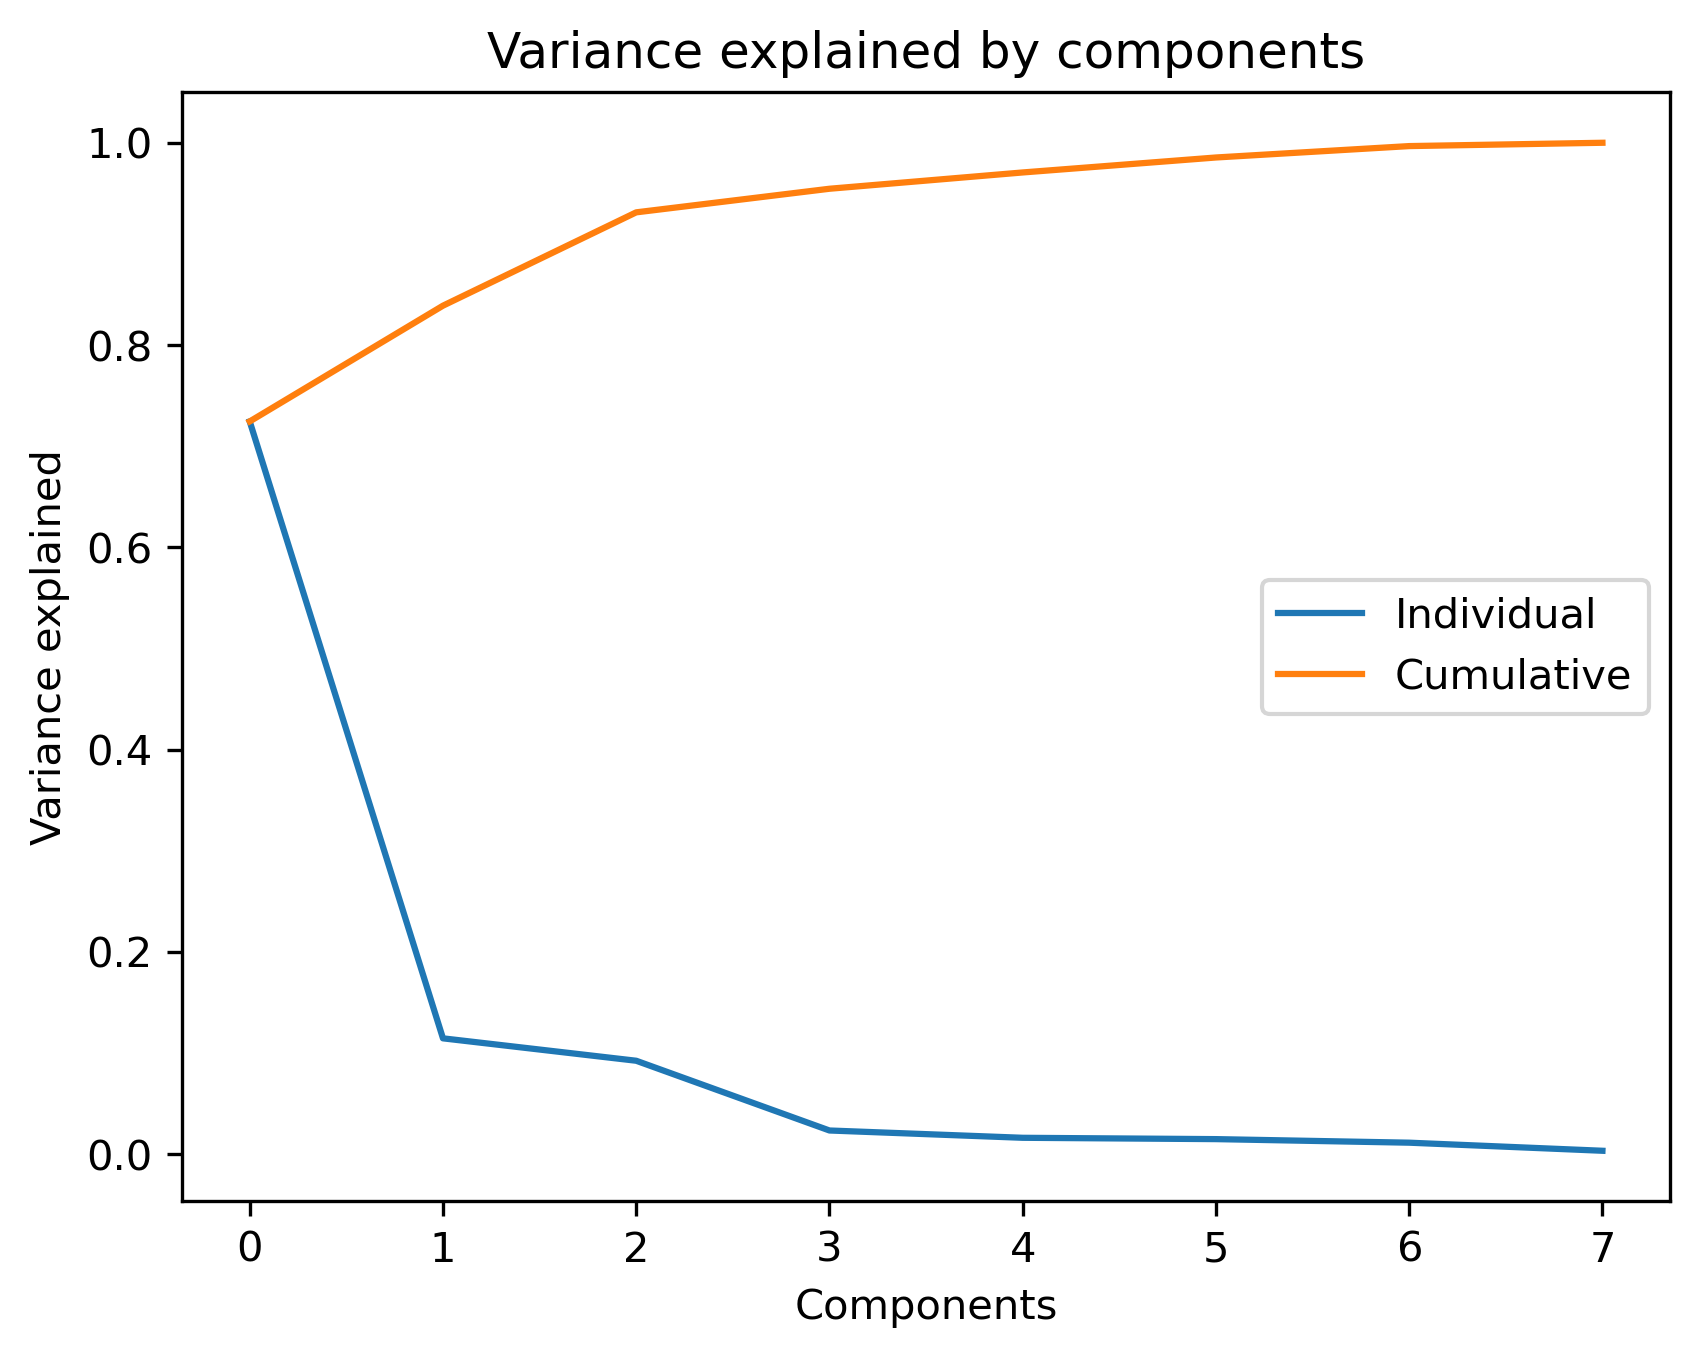

In [5]:
# Look at variance explained by the components
pca = PCA(n_components=8)
pca.fit(daily_centered[drug_list])
plt.figure(dpi=300)
plt.plot(pca.explained_variance_ratio_, label='Individual')
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative')
plt.title('Variance explained by components')
plt.xlabel('Components')
plt.ylabel('Variance explained')
plt.legend()
plt.savefig('../Figures/Supplementary_figure_1.png')
plt.show()

## PCA

In [6]:
sums = np.round(np.sum(daily[drug_list], axis=1))

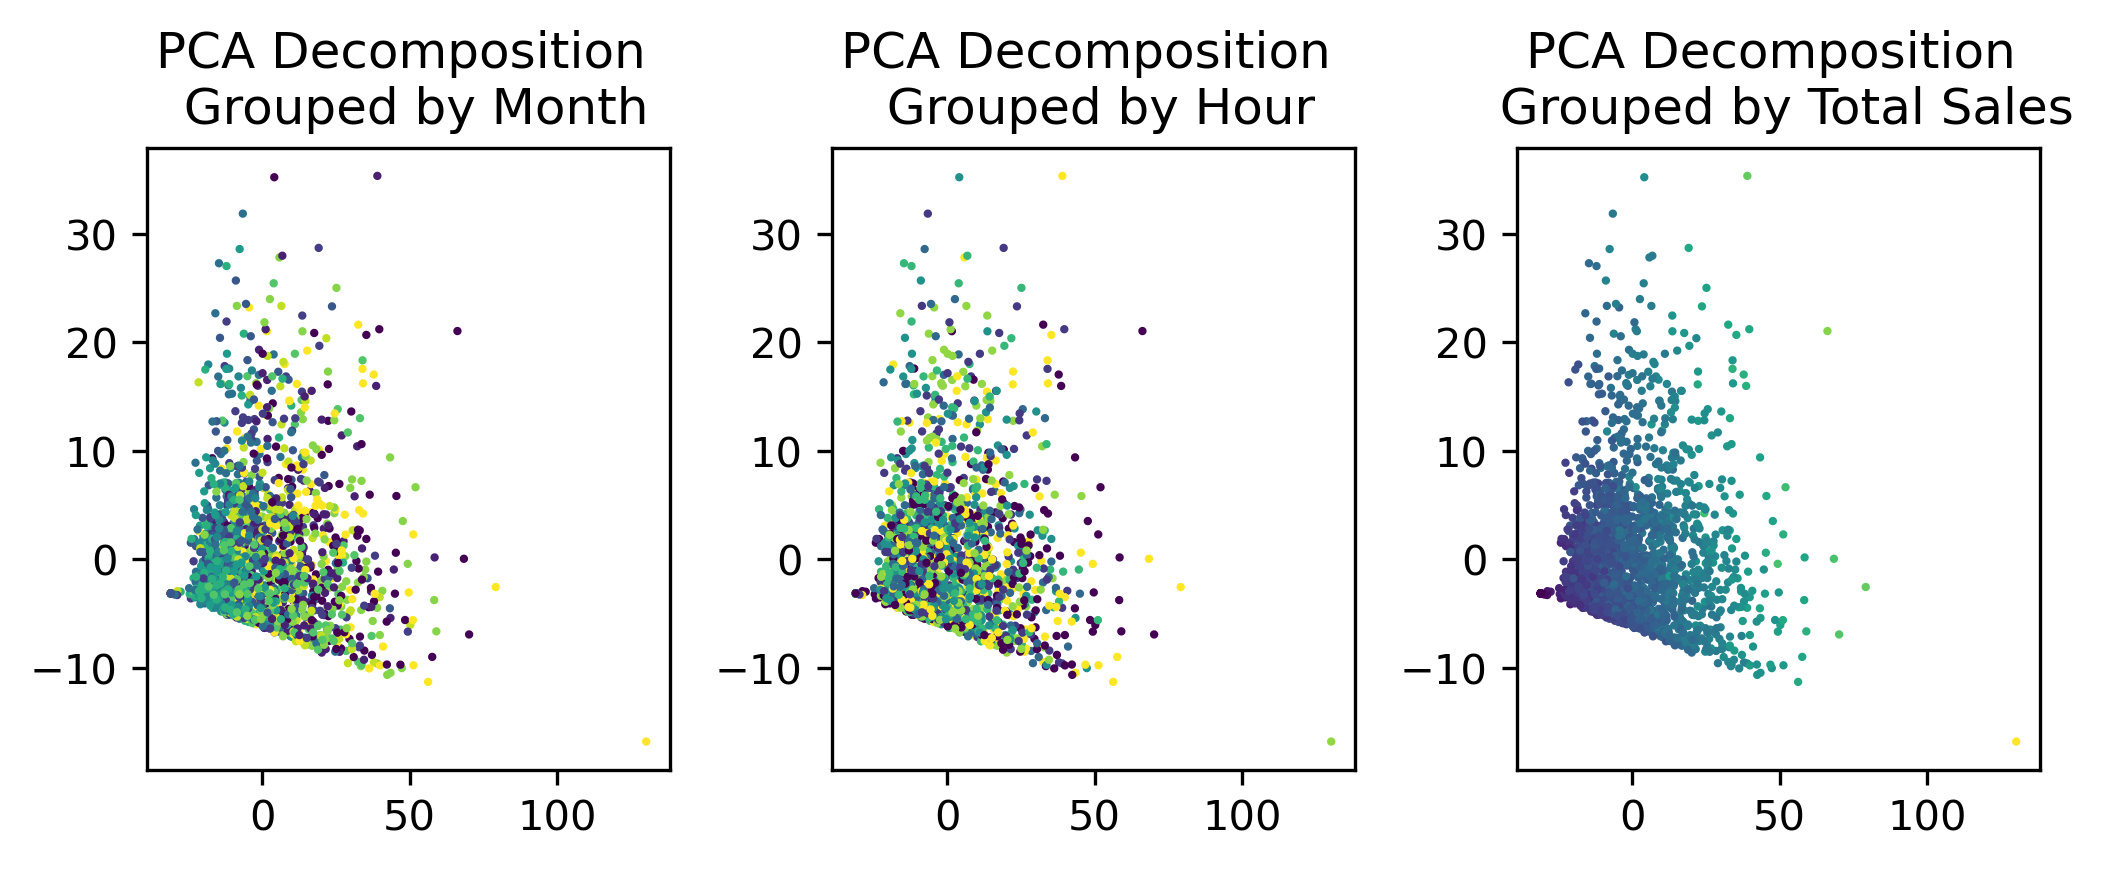

In [7]:
# Perform PCA
pca = PCA(n_components=2)
pca.fit(daily_centered[drug_list])
pca_daily_data = pca.transform(daily_centered[drug_list])

# Show plot
plt.figure(figsize=(7,3), dpi=300)
plt.subplot(1,3,1)
plt.scatter(pca_daily_data[:,0], pca_daily_data[:,1], s=1, 
            c=list(daily['Month']))
plt.title('PCA Decomposition \n Grouped by Month')

# Show plot
plt.subplot(1,3,2)
plt.scatter(pca_daily_data[:,0], pca_daily_data[:,1], s=1, 
            c=list(daily['Weekday Num']))
plt.title('PCA Decomposition \n Grouped by Hour')

# Show plot
plt.subplot(1,3,3)
plt.scatter(pca_daily_data[:,0], pca_daily_data[:,1], s=1, 
            c=sums)
plt.title('PCA Decomposition \n Grouped by Total Sales')

plt.tight_layout()
plt.savefig('../Figures/Figure_3.png')
plt.show()

# Clustering with Daily Data

In [8]:
# Fit Gaussian model
gmm = GaussianMixture(n_components=7)
gmm.fit(daily[drug_list])

# Get labels
labels = gmm.predict(daily[drug_list])
cluster_df = pd.DataFrame(daily[drug_list])
cluster_df['cluster'] = labels
cluster_df['day'] = list(daily['Weekday Num'])

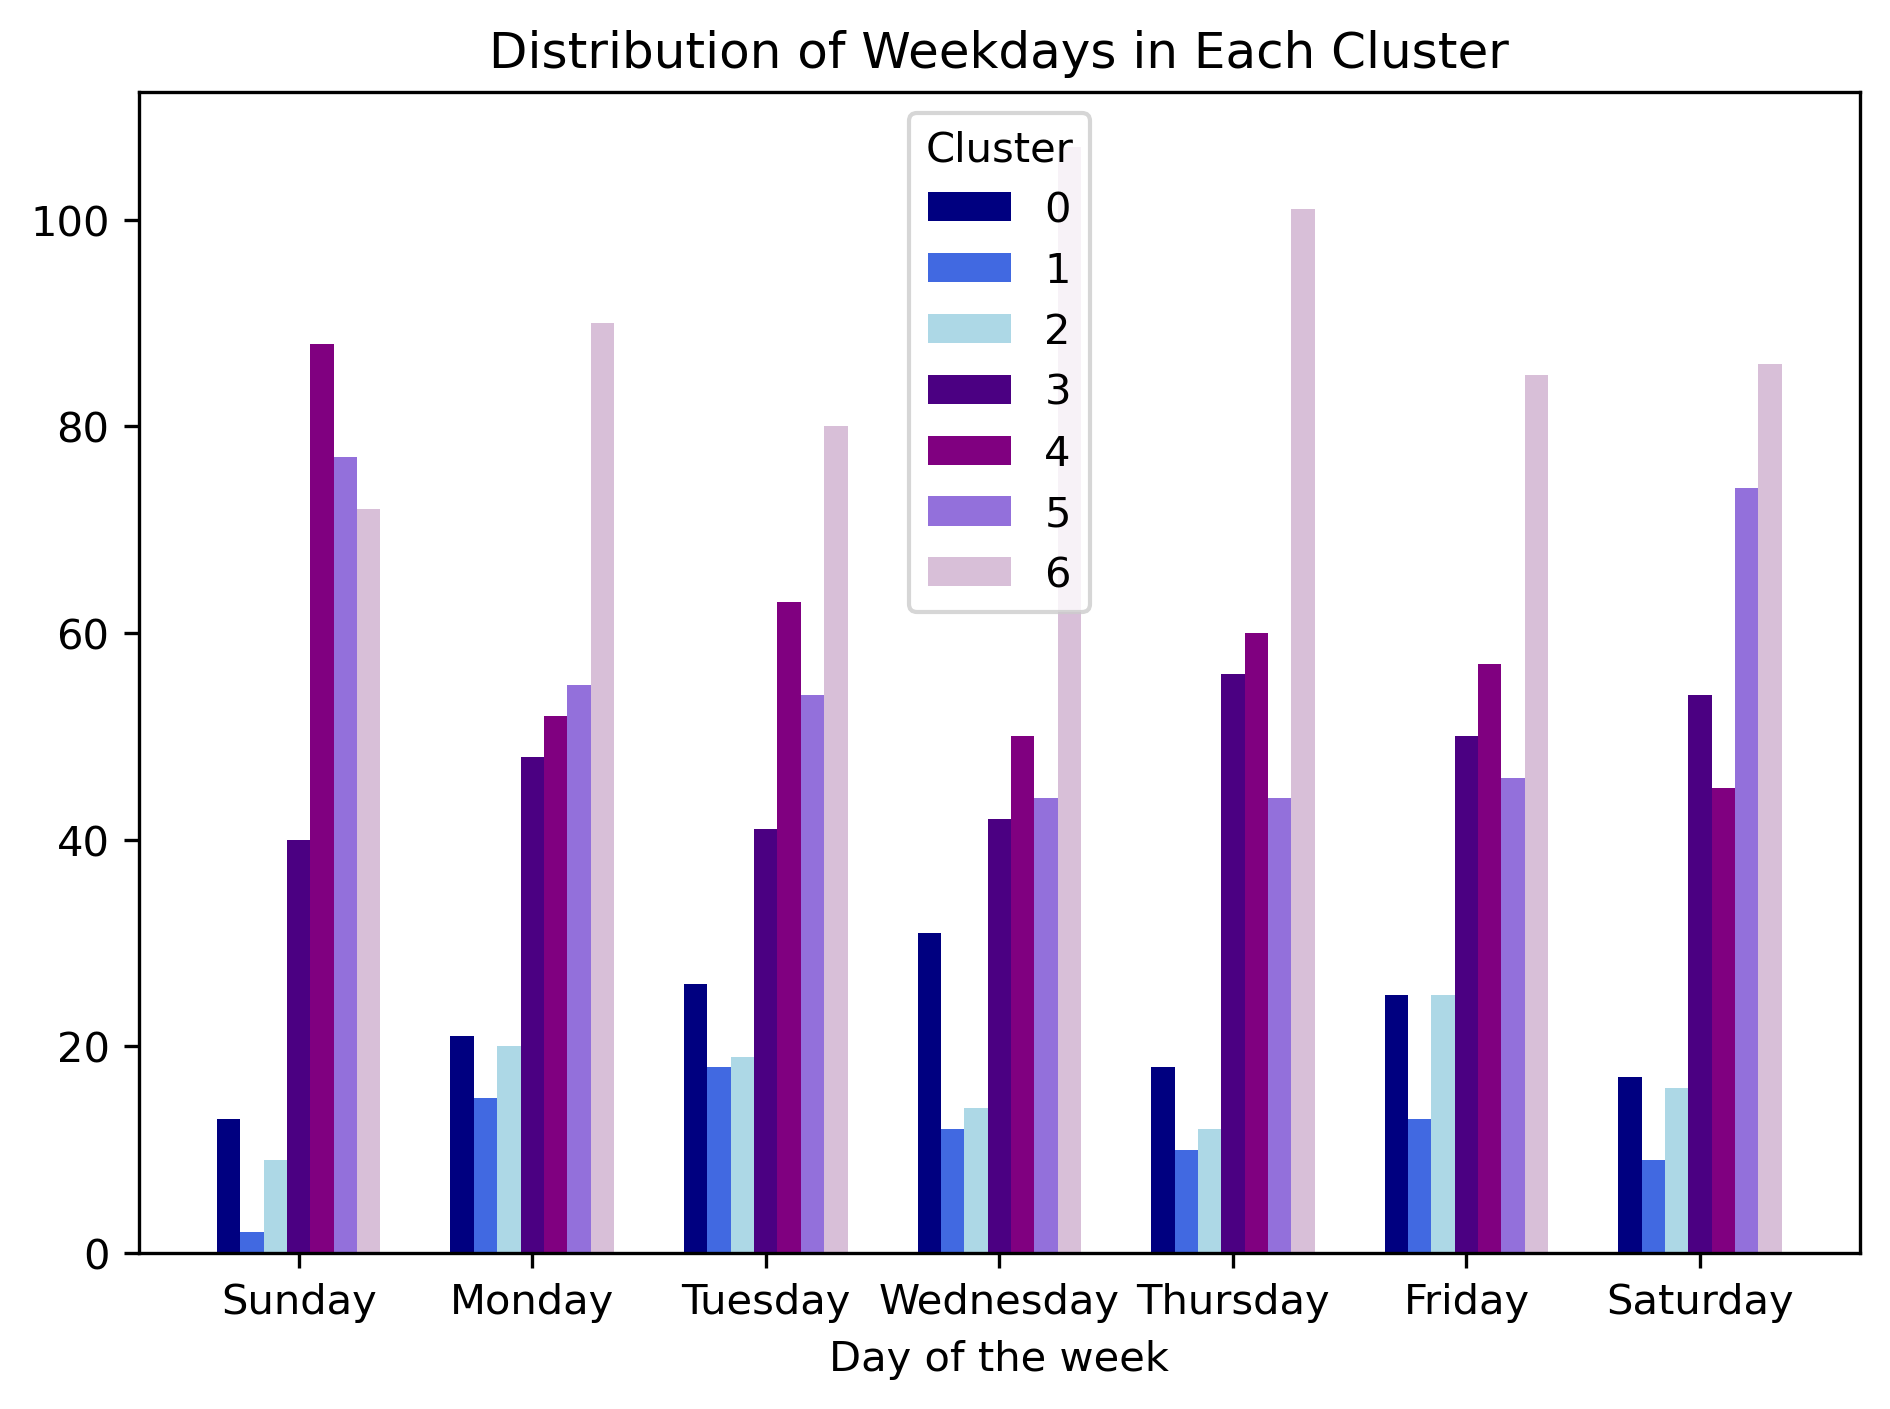

In [9]:
# Set initial variables
X = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
_X = np.arange(len(X))
location = [-.3,-.2,-.1,0,.1,.2,.3]
colors = ['navy', 'royalblue', 'lightblue', 'indigo', 'purple', 'mediumpurple','thistle']
plt.figure(dpi=300)

# Create plot
for i in range(7):
    labels = cluster_df.groupby('cluster').get_group(i)['day'].value_counts().sort_index()
    for j in range(1,8):
        if j not in labels.index.values:
            labels[j] = 0
    plt.bar(_X + location[i], list(labels), 0.1, label=i, color=colors[i])

# Show plot
plt.xticks(_X, X) # set labels manually
plt.xlabel('Day of the week')
plt.tight_layout()
plt.legend(title='Cluster')
plt.title('Distribution of Weekdays in Each Cluster')
plt.tight_layout()
plt.savefig('../Figures/Figure_4.png')
plt.show()

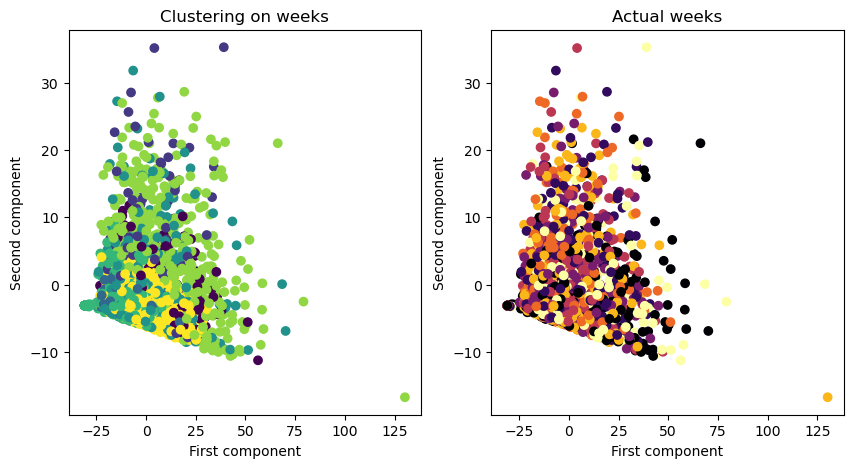

In [14]:
# Show plot of clustering on months
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(pca_daily_data[:,0], pca_daily_data[:,1], c=cluster_df['cluster'])
plt.title('Clustering on weeks')
plt.xlabel('First component')
plt.ylabel('Second component')

# Show plot of month labels
plt.subplot(1,2,2)
plt.scatter(pca_daily_data[:,0], pca_daily_data[:,1], c=cluster_df['day'],cmap='inferno')
plt.title('Actual weeks')
plt.ylabel('Second component')
plt.xlabel('First component')
plt.show()

In [15]:
# Fit Gaussian model
gmm_month = GaussianMixture(n_components=12)
gmm_month.fit(daily[drug_list])

# Get labels
labels_month = gmm_month.predict(daily[drug_list])
cluster_month_df = pd.DataFrame(daily[drug_list])
cluster_month_df['cluster'] = labels_month
cluster_month_df['month'] = list(daily['Month'])

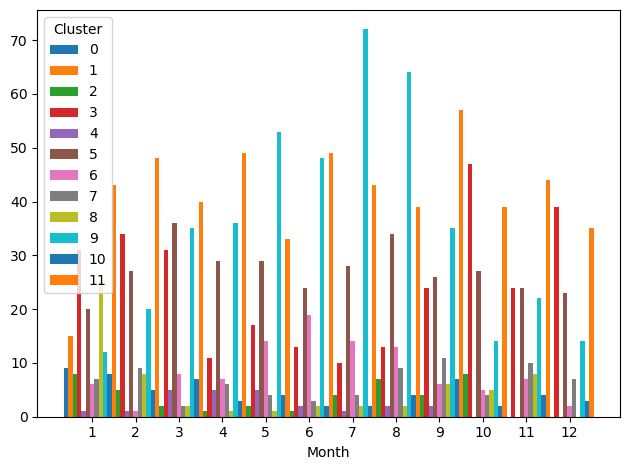

In [16]:
# Set initial variables
X = np.arange(1,13)
_X = np.arange(len(X))
location = [-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6]

# Create plot
for i in range(12):
    labels = cluster_month_df.groupby('cluster').get_group(i)['month'].value_counts().sort_index()
    for j in range(1,13):
        if j not in labels.index.values:
            labels[j] = 0
    plt.bar(_X + location[i], labels, 0.1, label=i)

# Show plot
plt.xticks(_X, X) # set labels manually
plt.xlabel('Month')
plt.tight_layout()
plt.legend(title='Cluster')
plt.show()

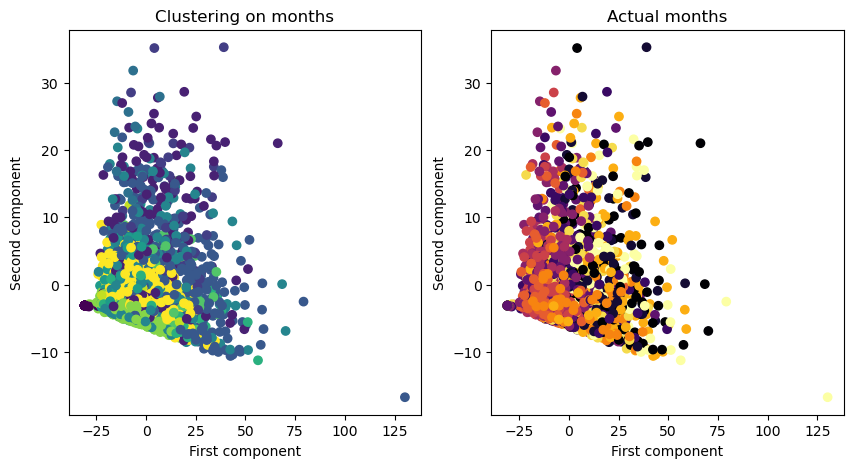

In [17]:
# Show plot of clustering on months
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(pca_daily_data[:,0], pca_daily_data[:,1], c=cluster_month_df['cluster'])
plt.title('Clustering on months')
plt.xlabel('First component')
plt.ylabel('Second component')

# Show plot of month labels
plt.subplot(1,2,2)
plt.scatter(pca_daily_data[:,0], pca_daily_data[:,1], c=cluster_month_df['month'],cmap='inferno')
plt.title('Actual months')
plt.ylabel('Second component')
plt.xlabel('First component')
plt.show()

# Look at means of clusters

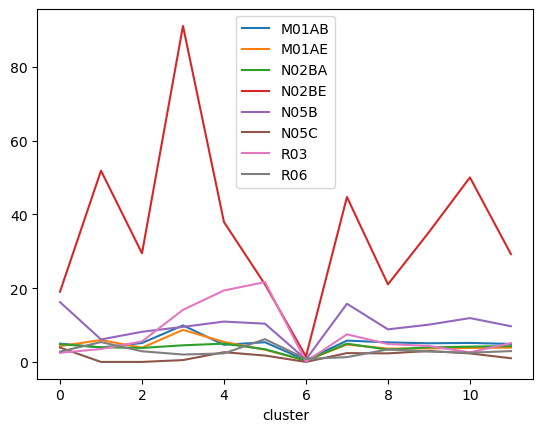

In [18]:
# Plot means of clusters
means = cluster_month_df.iloc[:,:9].groupby('cluster').mean()
for c in means.columns:
    plt.plot(means[c], label=c)
    plt.title('Means of clusters')
    
plt.legend()
plt.xlabel('cluster')
plt.show()
    

# Look at correlation between drugs

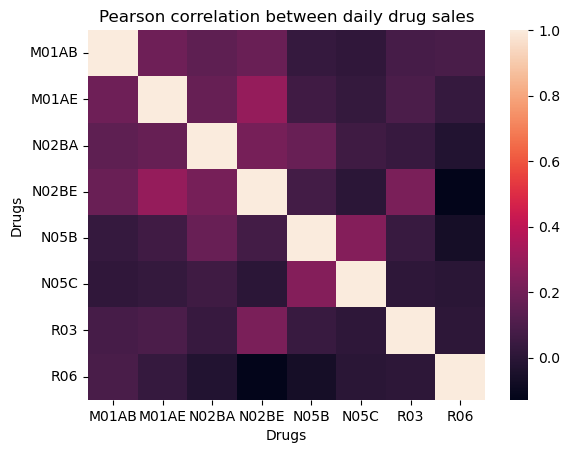

In [23]:
# Set initial variables
n = len(drug_list)
correlation = pd.DataFrame(columns=drug_list, index=drug_list)

# Get correlation between drug sales
for drug in drug_list:
    for drug_2 in drug_list:
        correlation.loc[drug,drug_2] = float(pearsonr(daily[drug], daily[drug_2])[0])

# Create plot
correlation = correlation.astype('float')
sns.heatmap(correlation)
plt.xlabel('Drugs')
plt.ylabel('Drugs')
plt.title('Pearson correlation between daily drug sales')
plt.show()